## Introduction

training a custom music genre classification system with the GTZAN dataset. The model takes as an input the spectogram of music frames and analyzes the image using a Convolutional Neural Network (CNN) or a Recurrent Neural Network (RNN). The output of the system is a vector of predicted genres for the song.

 ## Data Dictionary
    
        "blues" = 1,
        "classical" = 2,
        "country" = 3,
        "disco" = 4,
        "hiphop" = 5,
        "jazz"  = 6,
        "metal" = 7,
        "pop" = 8,
        "rock" = 9

## Loading and splitting the data 

In [1]:
import numpy as np
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
DATASET_PATH = "data.json"

In [2]:
def prepare_datasets(test_size, validation_size):
    #load data
    X, y = load_data(DATASET_PATH)
    # train/test split & train/validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # for a CNN , Tensorflow expects a 3D array for each sample? --> (130 time bins and 13 mfccs)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [3]:

def load_data(dataset_path):
    with open(dataset_path, "r") as file:
        data = json.load(file)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print("Data succesfully loaded!")

    return  X, y
    
if __name__ == "__main__":
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    
    

Data succesfully loaded!


## Building the network architecture with keras

In [4]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [5]:
def build_model(input_shape):
    #create model
    model = keras.Sequential()
    #1st conv layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    #2nd conv layer
    model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    #3rd conv layer
    model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    # flatten and feed into the dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))
    
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    # output
    model.add(layers.Dense(10, activation='softmax'))
    
    return model
    

In [6]:
keras.backend.clear_session()
model = build_model(input_shape)

In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 5, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 3, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 3, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 2, 32)         4

## Compile and train the network

In [48]:
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [49]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50, callbacks=[es_callback])

Train on 592 samples, validate on 149 samples
Epoch 1/50
592/592 [==============================] - 1s 2ms/sample - loss: 2.4890 - accuracy: 0.1892 - val_loss: 2.3320 - val_accuracy: 0.1477
Epoch 2/50
592/592 [==============================] - 0s 461us/sample - loss: 1.7792 - accuracy: 0.3851 - val_loss: 2.2386 - val_accuracy: 0.2148
Epoch 3/50
592/592 [==============================] - 0s 453us/sample - loss: 1.4023 - accuracy: 0.4899 - val_loss: 2.1322 - val_accuracy: 0.2685
Epoch 4/50
592/592 [==============================] - 0s 454us/sample - loss: 1.1056 - accuracy: 0.5828 - val_loss: 1.5645 - val_accuracy: 0.4228
Epoch 5/50
592/592 [==============================] - 0s 490us/sample - loss: 1.0228 - accuracy: 0.6486 - val_loss: 1.3243 - val_accuracy: 0.4899
Epoch 6/50
592/592 [==============================] - 0s 470us/sample - loss: 0.8984 - accuracy: 0.7027 - val_loss: 1.1175 - val_accuracy: 0.5436
Epoch 7/50
592/592 [==============================] - 0s 490us/sample - loss: 0.

In [50]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy on test set is: {test_accuracy}")

248/248 [==============================] - 0s 339us/sample - loss: 0.5447 - accuracy: 0.8387
Accuracy on test set is: 0.8387096524238586


In [51]:
def predict(model, X, y):
    X = X[np.newaxis, ...]
    # prediction = [[0.1, 0.2, ...]]
    prediction = model.predict(X)
    #extract index with max value
    predicted_index = np.argmax(prediction, axis=1) # [i] index that is predicted
    print(f"Expected index: {y}, predicted index: {predicted_index}")

In [52]:
for i in range(0, 110, 10):
    X = X_test[i]
    y = y_test[i]
    predict(model, X, y)

Expected index: 4, predicted index: [4]
Expected index: 5, predicted index: [5]
Expected index: 2, predicted index: [2]
Expected index: 9, predicted index: [9]
Expected index: 8, predicted index: [8]
Expected index: 1, predicted index: [1]
Expected index: 2, predicted index: [2]
Expected index: 8, predicted index: [8]
Expected index: 2, predicted index: [2]
Expected index: 9, predicted index: [9]
Expected index: 9, predicted index: [9]


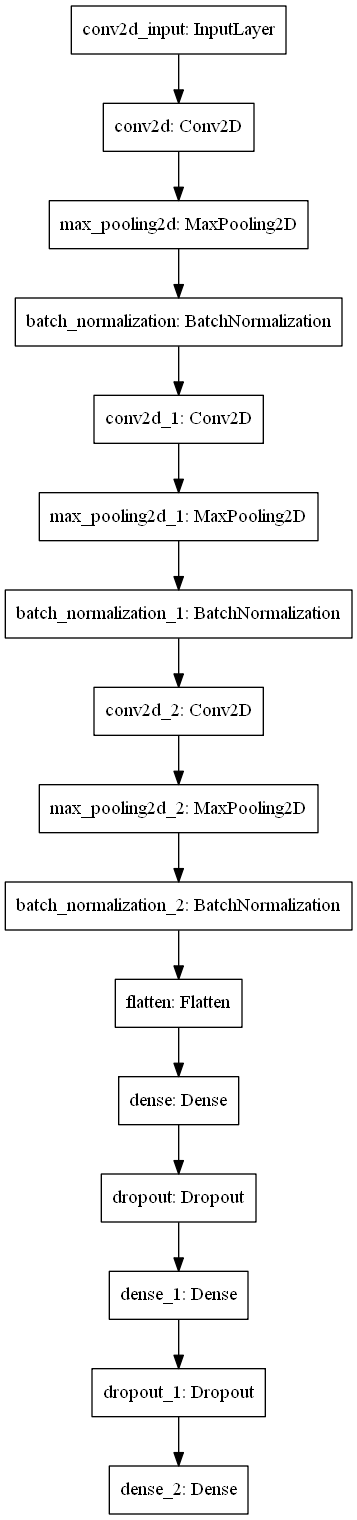

In [9]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)